# IMDB: TEXT Classification + BERT + Ax

## Librairies

In [2]:
import os
import sys

In [5]:
import io
import re
import pickle
from timeit import default_timer as timer

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import AutoTokenizer
from transformers import BertModel
from transformers.data.data_collator import DataCollatorWithPadding

from ax import optimize
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting

import esntorch.core.reservoir as res
import esntorch.core.learning_algo as la
import esntorch.core.merging_strategy as ms
import esntorch.core.esn as esn

In [6]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
SEED = 42

## Load params

In [7]:
def wrapped_fitness(d, return_test_acc=False):
    
    return fitness(leaking_rate=d['leaking_rate'],
                   spectral_radius=d['spectral_radius'],
                   input_scaling=d['input_scaling'],
                   bias_scaling=d['bias_scaling'],
                   alpha=d['alpha'],
                   reservoir_dim=d['reservoir_dim'], # will be in the loop
                   dataset_d=dataset_d,
                   dataloader_d=dataloader_d,
                   return_test_acc=return_test_acc)

In [8]:
with open("~/Results/Ax_results/ESN/imdb_params_1.pkl", "rb") as fh:
    imdb_params = pickle.load(fh)

In [9]:
imdb_params

{500: {'best_parameters': {'leaking_rate': 0.999,
   'spectral_radius': 0.5727747785131674,
   'input_scaling': 2.2779062575285725,
   'bias_scaling': 0.343925600580577,
   'alpha': 47.689935194630536,
   'reservoir_dim': 500},
  'best_values': ({'val_accuracy': 88.40578001236312},
   {'val_accuracy': {'val_accuracy': 0.00010199969003581719}}),
  'experiment': SimpleExperiment(None)},
 1000: {'best_parameters': {'leaking_rate': 0.4987849139827162,
   'spectral_radius': 1.6999999999999982,
   'input_scaling': 1.4110756942379619,
   'bias_scaling': 0.35271864878994974,
   'alpha': 103.97613075779954,
   'reservoir_dim': 1000},
  'best_values': ({'val_accuracy': 89.1698804001885},
   {'val_accuracy': {'val_accuracy': 0.0001586215379122042}}),
  'experiment': SimpleExperiment(None)},
 2000: {'best_parameters': {'leaking_rate': 0.3965251182814235,
   'spectral_radius': 1.0298126353747301,
   'input_scaling': 0.4442265453597545,
   'bias_scaling': 3.0,
   'alpha': 107.19441242615346,
   'res

## Define model

In [12]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [13]:
def compute_mse_diff(ESN, return_distances=False):
    
    input_w = ESN.reservoir.input_w
    
    with open("random_words.csv", "rt") as fh:
        random_words = [x[:-1] for x in fh.readlines()]
        
    tokenized_random_words = tokenizer.batch_encode_plus(random_words, add_special_tokens=False, padding=False)
    
    simple_words = []
    for i,ids in enumerate(tokenized_random_words["input_ids"]):
        if len(ids) == 1:
            simple_words.append(random_words[i])
            
    tokenized_simple_random_words = tokenizer.batch_encode_plus(simple_words, add_special_tokens=False, return_tensors="pt")
    
    # Get BERT embeddings
    bert_embedded_words = ESN.reservoir.embedding(tokenized_simple_random_words).squeeze()
    
    # Get distances $d_{i,j}$
    distances_BERT = cosine_distances(bert_embedded_words.cpu().numpy())

    # Get transformed BERT embeddings
    bert_embedded_words_transformed = torch.mm(bert_embedded_words, input_w.T)

    # Get distances $d'_{i,j}$
    distances_transformed = cosine_distances(bert_embedded_words_transformed.cpu().numpy())
    
    # $\frac{\sum{|d_{i,j} - d'_{i,j}|}^2}{2*n} $
    mse_transformation = ((distances_BERT - distances_transformed) ** 2).mean()/2
    
    # $\frac{\sum{|d_{i,j} - d'_{k,l}|}^2}{2*n}   k,l \in [1...n]\text{ randomly}$
    random_distances = distances_transformed.flatten()
    random_distances = random_distances[random_distances != 0]
    random_distances = np.random.choice(random_distances, size=(len(distances_transformed), len(distances_transformed)), replace=True)
    np.fill_diagonal(random_distances, 0)
    
    mse_random = ((distances_BERT - random_distances) ** 2).mean()/2

    if return_distances:
        return mse_transformation, mse_random, distances_BERT, distances_transformed, random_distances
    else:
        return mse_transformation, mse_random

In [14]:
sum_normal_mse = {}
sum_random_mse = {}

for size_esn in [500, 1000, 3000, 5000]:
    print(f"testing size {size_esn}")

    best_params = imdb_params[size_esn]["best_parameters"]

    # parameters
    esn_params = {
                'embedding_weights': 'bert-base-uncased', # TEXT.vocab.vectors,
                'distribution' : 'uniform',              # uniform, gaussian
                'input_dim' : 768,                       # dim of encoding!
                'reservoir_dim' : best_params["reservoir_dim"],
                'bias_scaling' : best_params["bias_scaling"],
                'sparsity' : 0.99,
                'spectral_radius' : best_params["spectral_radius"],
                'leaking_rate': best_params["leaking_rate"],
                'activation_function' : 'tanh',
                'input_scaling' : best_params["input_scaling"],
                'mean' : 0.0,
                'std' : 1.0,
                'learning_algo' : None,
                'criterion' : None,
                'optimizer' : None,
                'merging_strategy' : 'mean',
                'lexicon' : None,
                'bidirectional' : False, # False
                'device' : device,
                'seed' : 42
                 }

    sum_normal_mse[size_esn] = []
    sum_random_mse[size_esn] = []


    for seed in [42, 1024, 16873298, 1996, 2019]:
        print(f"\ttesting seed {seed}")

        esn_params['seed'] = seed

        # model
        ESN = esn.EchoStateNetwork(**esn_params)
        ESN.learning_algo = la.RidgeRegression(alpha = best_params["alpha"])# , mode='normalize')
        ESN = ESN.to(device)

        mse_transformation, mse_random = compute_mse_diff(ESN)

        sum_normal_mse[size_esn].append(mse_transformation)
        sum_random_mse[size_esn].append(mse_random)

        print(f"\t\tmse of the normal transformation : {mse_transformation}\n\t\tmse of the random transformation : {mse_random}")

testing size 500
	testing seed 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.0006021367153152823
		mse of the random transformation : 0.016327379271388054
	testing seed 1024


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.0008832113235257566
		mse of the random transformation : 0.015797536820173264
	testing seed 16873298


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.0006756293587386608
		mse of the random transformation : 0.01589079387485981
	testing seed 1996


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.0006633711745962501
		mse of the random transformation : 0.016319435089826584
	testing seed 2019


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.0007923736120574176
		mse of the random transformation : 0.015535215847194195
testing size 1000
	testing seed 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.0003902955213561654
		mse of the random transformation : 0.015479129739105701
	testing seed 1024


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.00038061352097429335
		mse of the random transformation : 0.015859253704547882
	testing seed 16873298


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.00037621494266204536
		mse of the random transformation : 0.015357490628957748
	testing seed 1996


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.00034165073884651065
		mse of the random transformation : 0.01575501076877117
	testing seed 2019


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.00031244452111423016
		mse of the random transformation : 0.015558995306491852
testing size 3000
	testing seed 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.00010078657214762643
		mse of the random transformation : 0.015603702515363693
	testing seed 1024


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.00010628730524331331
		mse of the random transformation : 0.015626879408955574
	testing seed 16873298


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.00010674318036762998
		mse of the random transformation : 0.015474600717425346
	testing seed 1996


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.00012406730093061924
		mse of the random transformation : 0.015408982522785664
	testing seed 2019


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.00012528877414297312
		mse of the random transformation : 0.015296519733965397
testing size 5000
	testing seed 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 7.548701978521422e-05
		mse of the random transformation : 0.015617839992046356
	testing seed 1024


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 6.99061420164071e-05
		mse of the random transformation : 0.015679847449064255
	testing seed 16873298


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 5.873822374269366e-05
		mse of the random transformation : 0.015534666366875172
	testing seed 1996


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 7.645990990567952e-05
		mse of the random transformation : 0.015333504416048527
	testing seed 2019


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


		mse of the normal transformation : 0.00011495587386889383
		mse of the random transformation : 0.015302738174796104


In [16]:
sum_normal_mse

{500: [0.0006021367153152823,
  0.0008832113235257566,
  0.0006756293587386608,
  0.0006633711745962501,
  0.0007923736120574176],
 1000: [0.0003902955213561654,
  0.00038061352097429335,
  0.00037621494266204536,
  0.00034165073884651065,
  0.00031244452111423016],
 3000: [0.00010078657214762643,
  0.00010628730524331331,
  0.00010674318036762998,
  0.00012406730093061924,
  0.00012528877414297312],
 5000: [7.548701978521422e-05,
  6.99061420164071e-05,
  5.873822374269366e-05,
  7.645990990567952e-05,
  0.00011495587386889383]}

In [17]:
sum_random_mse

{500: [0.016327379271388054,
  0.015797536820173264,
  0.01589079387485981,
  0.016319435089826584,
  0.015535215847194195],
 1000: [0.015479129739105701,
  0.015859253704547882,
  0.015357490628957748,
  0.01575501076877117,
  0.015558995306491852],
 3000: [0.015603702515363693,
  0.015626879408955574,
  0.015474600717425346,
  0.015408982522785664,
  0.015296519733965397],
 5000: [0.015617839992046356,
  0.015679847449064255,
  0.015534666366875172,
  0.015333504416048527,
  0.015302738174796104]}

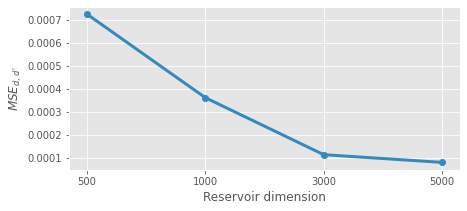

In [34]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(7,3))

mse_1 = {k: np.mean(v) for k, v in sum_normal_mse.items()}
mse_2 = {k: np.mean(v) for k, v in sum_random_mse.items()}

# ax.errorbar(range(len(acc_d)), acc_l, yerr=std_l, fmt='-', color='C1', linewidth=2)
ax.plot(range(len(mse_1)), mse_1.values(), marker='o', color='C1', linewidth=3)
# ax.plot(range(len(mse_1)), mse_2.values(), marker='o', color='C1', linewidth=3)

# ax.set_title('Test Accuracy of an ESN over IMDB dataset')

ax.set_xticks(range(len(mse_1)))
ax.set_xticklabels(mse_1.keys())

ax.set_xlabel('Reservoir dimension')
ax.set_ylabel("$MSE_{d,d'}$")

plt.savefig("MSE_cosine_dist.pdf", bbox_inches='tight', dpi=300)
plt.show()

# Test same thing when passing through reservoir

## Load dataset

In [399]:
# rename correct column as 'labels': depends on the dataset you load

def load_and_enrich_dataset(dataset_name, split, cache_dir):
    
    dataset = load_dataset(dataset_name, split=split, cache_dir=CACHE_DIR)
    dataset = dataset.rename_column('label', 'labels') # cf 'imdb' dataset
    dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding=False), batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    def add_lengths(sample):
        sample["lengths"] = sum(sample["input_ids"] != 0)
        return sample
    
    dataset = dataset.map(add_lengths, batched=False)
    
    return dataset

In [400]:
CACHE_DIR = '~/Data/huggignface/' # put your own path here

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

full_train_dataset = load_and_enrich_dataset('imdb', split='train', cache_dir=CACHE_DIR).sort("lengths") # toriving/sst5
train_val_datasets = full_train_dataset.train_test_split(train_size=0.8, shuffle=True)
train_dataset = train_val_datasets['train'].sort("lengths")
val_dataset = train_val_datasets['test'].sort("lengths")

test_dataset = load_and_enrich_dataset('imdb', split='test', cache_dir=CACHE_DIR).sort("lengths")

dataset_d = {
    'full_train': full_train_dataset,
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
    }

dataloader_d = {}
for k, v in dataset_d.items():
    dataloader_d[k] = torch.utils.data.DataLoader(v, 
                                                  batch_size=128,#256, reduced for bi-direction
                                                  collate_fn=DataCollatorWithPadding(tokenizer))

Reusing dataset imdb (/raid/home/jeremiec/huggingface_datasets/imdb/plain_text/1.0.0/4ea52f2e58a08dbc12c2bd52d0d92b30b88c00230b4522801b3636782f625c5b)


Reusing dataset imdb (/raid/home/jeremiec/huggingface_datasets/imdb/plain_text/1.0.0/4ea52f2e58a08dbc12c2bd52d0d92b30b88c00230b4522801b3636782f625c5b)


In [401]:
dataset_d

{'full_train': Dataset({
     features: ['attention_mask', 'input_ids', 'labels', 'lengths', 'text', 'token_type_ids'],
     num_rows: 25000
 }),
 'train': Dataset({
     features: ['attention_mask', 'input_ids', 'labels', 'lengths', 'text', 'token_type_ids'],
     num_rows: 20000
 }),
 'val': Dataset({
     features: ['attention_mask', 'input_ids', 'labels', 'lengths', 'text', 'token_type_ids'],
     num_rows: 5000
 }),
 'test': Dataset({
     features: ['attention_mask', 'input_ids', 'labels', 'lengths', 'text', 'token_type_ids'],
     num_rows: 25000
 })}

In [405]:
ESN.reservoir.initial_state.shape

torch.Size([5000])

In [407]:
ESN.reservoir.bias.shape

torch.Size([5000])

In [494]:
def compute_mse_after_reservoir(ESN, return_distances=False):
    
    with open("random_words.csv", "rt") as fh:
        random_words = [x[:-1] for x in fh.readlines()]
        
    tokenized_random_words = tokenizer.batch_encode_plus(random_words, add_special_tokens=False, padding=False)
    
    simple_words = []
    for i,ids in enumerate(tokenized_random_words["input_ids"]):
        if len(ids) == 1:
            simple_words.append(random_words[i])
            
    tokenized_simple_random_words = tokenizer.batch_encode_plus(simple_words, add_special_tokens=False, return_tensors="pt")
    
    # ESN reservoir parameters
    input_w = ESN.reservoir.input_w
    reservoir_w = ESN.reservoir.reservoir_w
    reservoir_bias = ESN.reservoir.bias
    reservoir_x0 = ESN.reservoir.initial_state
    
    # Get BERT embeddings
    bert_embedded_words = ESN.reservoir.embedding(tokenized_simple_random_words).squeeze()
    
    # Get distances $d_{i,j}$
    distances_BERT = cosine_distances(bert_embedded_words.cpu().numpy())

    # Get transformed BERT embeddings : apply manually the reservoir once
    processing = torch.mm(bert_embedded_words, input_w.T)
    inter = torch.mm(reservoir_w, reservoir_x0.reshape((-1, 1))).unsqueeze(0).repeat((785, 1, 1)).squeeze()
    processing = processing + inter + reservoir_bias.unsqueeze(0).repeat((785, 1))
    bert_embedded_words_transformed = torch.tanh(processing)

    # Get distances $d'_{i,j}$
    distances_transformed = cosine_distances(bert_embedded_words_transformed.cpu().numpy())
    
    # $\frac{\sum{|d_{i,j} - d'_{i,j}|}^2}{2*n} $
    mse_transformation = ((distances_BERT - distances_transformed) ** 2).mean()/2

    if return_distances:
        return mse_transformation, distances_BERT, distances_transformed
    else:
        return mse_transformation

In [497]:
dataset_d["train"].select([1])

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'lengths', 'text', 'token_type_ids'],
    num_rows: 1
})

In [495]:
sum_normal_mse = {}

for size_esn in [500, 1000, 3000, 5000]:
    print(f"testing size {size_esn}")

    best_params = imdb_params[size_esn]["best_parameters"]

    # parameters
    esn_params = {
                'embedding_weights': 'bert-base-uncased', # TEXT.vocab.vectors,
                'distribution' : 'uniform',              # uniform, gaussian
                'input_dim' : 768,                       # dim of encoding!
                'reservoir_dim' : best_params["reservoir_dim"],
                'bias_scaling' : best_params["bias_scaling"],
                'sparsity' : 0.99,
                'spectral_radius' : best_params["spectral_radius"],
                'leaking_rate': best_params["leaking_rate"],
                'activation_function' : 'tanh',
                'input_scaling' : best_params["input_scaling"],
                'mean' : 0.0,
                'std' : 1.0,
                'learning_algo' : None,
                'criterion' : None,
                'optimizer' : None,
                'merging_strategy' : 'mean',
                'lexicon' : None,
                'bidirectional' : False, # False
                'device' : device,
                'seed' : 42
                 }

    sum_normal_mse[size_esn] = []


    for seed in [42, 1024, 16873298, 1996, 2019]:
        print(f"\ttesting seed {seed}")

        esn_params['seed'] = seed

        # model
        ESN = esn.EchoStateNetwork(**esn_params)
        ESN.learning_algo = la.RidgeRegression(alpha = best_params["alpha"])# , mode='normalize')
        ESN = ESN.to(device)
        
        # warm up (new)
        nb_sentences = 3
        for i in range(nb_sentences): 

            sentence = dataset_d["train"].select([i])
            dataloader_tmp = torch.utils.data.DataLoader(sentence, 
                                                         batch_size=1, 
                                                         collate_fn=DataCollatorWithPadding(tokenizer))  

            for s in dataloader_tmp:
                ESN.warm_up(s)

        mse_transformation = compute_mse_after_reservoir(ESN)

        sum_normal_mse[size_esn].append(mse_transformation)

        print(f"\t\tmse of the normal transformation : {mse_transformation}")

testing size 500
	testing seed 42
		mse of the normal transformation : 0.006634519435465336
	testing seed 1024
		mse of the normal transformation : 0.0059072538278996944
	testing seed 16873298
		mse of the normal transformation : 0.006588850170373917
	testing seed 1996
		mse of the normal transformation : 0.006834477186203003
	testing seed 2019
		mse of the normal transformation : 0.007324102334678173
testing size 1000
	testing seed 42
		mse of the normal transformation : 0.0046043312177062035
	testing seed 1024
		mse of the normal transformation : 0.0050125219859182835
	testing seed 16873298
		mse of the normal transformation : 0.005555033218115568
	testing seed 1996
		mse of the normal transformation : 0.0062471111305058
	testing seed 2019
		mse of the normal transformation : 0.005521882325410843
testing size 3000
	testing seed 42
		mse of the normal transformation : 0.001587049919180572
	testing seed 1024
		mse of the normal transformation : 0.0015077058924362063
	testing seed 16873